# Coursework 3: Generative Models

#### Instructions

Please submit on CATe a zip file named *CW3.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question.
2. Your trained models as *CAE_model.pth, DCGAN_model_D.pth, DCGAN_model_G.pth*
3. You training losses as *train_losses_CAE.npy*, *train_losses_D.npy*, *train_losses_G.npy*

#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 28th February, 2019**

## Introduction

For this coursework you are asked to implement two commonly used generative models:
1. A **Convolutional Autoencoder (CAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

The dataset you will be using is the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1 (50 points)

1. For the CAE, the success of your models will be tested as follows:
    - **By the autoencoders' reconstruction error**. You will need to achieve a low enough error in order to reconstruct the images of the dataset with relatively high fidelity. You will have to provide us with your best model's training loss curve, reconstruction error on the test set and some reconstructed images in the respective cells.
    - **By the representation learning capabilities of your model**. In particular, autoencoders are known to be able to learn quite informative features in their latent space (embeddings) that can later be used for downstream tasks. In this coursework you are asked to use the representations that your pre-trained encoder yields in order to do image classification. You can use your favourite classification module on top of the features in order to solve the problem *(Hint: a simple Support Vector Machine - SVM - is acceptable. Alternatively, you can devise more complex models such as a Multilayer Fully Connected Network)*.
 
## Part 2 (50 points)
2. For the DCGAN, The success of your models will be tested as follows:
    - **By the model's training error**. You will need to achieve relatively balanced errors for the generator and the discriminator of your model in order to sample realistic images from the generator. You will have to provide us with your best model's training losses curves, a discussion on how you concluded to the chosen architecture, and visualizations of generated samples in the respective cells. Your results do not have to be perfect, however a good discussion on the choice of architecture will be valued.
    - **By avoiding mode collapse**. A common problem of training GANs is that they end up generating only a few different samples (if not only one), rather than learning the whole distribution of the training data. This problem is referred to as mode collapse. You will need to make a discussion on whether you noticed mode collapse or not during your experimentation and if yes, how you addressed it.


In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131322 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
import os
os.chdir("drive/Colab Notebooks/460/coursework/cw3/")

In [0]:
import os
from time import time 
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


### Device Selection

In [0]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


### Reproducibility

In [0]:
# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

### Data loading

In [0]:
batch_size = 128

if not os.path.exists('./CW/CAE'):
    os.makedirs('./CW/CAE')
if not os.path.exists('./CW/DCGAN'):
    os.makedirs('./CW/DCGAN')

NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

data_dir = './datasets'
cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]
save_image(denorm(fixed_input), './CW/CAE/input_sample.png')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Part 1 - Convolutional Autoencoder

### Part 1.1 (30 points)
**Your Task**: 

a. Implement the CAE architecture. Fill in the missing parts in the cells below in order to complete the CAE class. You will need to define:

- The hyperparameters
- The constructor
- `encode`
- `decode`

b. Plot your training loss curve (x-axis: epochs, y-axis: loss)

c. Calculate the reconstruction error on your test set

d. Visualize a subset of the images of the test set and their reconstructions

For b., c. and d. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Some reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer or fully connected layer.
- use the appropriate activation functions. 
- Encoder module: hierarchially downsample your images with pooling layers, or strided convolutions.
- Decoder module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices. **You will need to choose sufficiently large size for your latent vectors (hidden_size variable), in order to allow enough capacity for your network to represent the data.**

The number of epochs that will be needed in order to train the network will vary depending on your choices. In most of the cases, it will be a long procedure (a few hours), so you can leave your notebook running until the training converges.  You don't need to train the network to an extreme if you don't have the time. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture.

### Hyper-parameter selection

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose the number of epochs and the learning rate.
num_epochs = 20
learning_rate  = 0.001
###

# Define here other hyperparameters that you used.


### Define model

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose a value for the latent space dimension and use it in your model
hidden_size = 128
image_size = 32*32
###

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        ##encoder layers##
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 3, stride=2, padding=1), #batch,16,16,16
            nn.BatchNorm2d(16), #C from an expected input of size (N, C, H, W)
            nn.ReLU(True),
            nn.Conv2d(16, 64, 3, stride=2, padding=1),#batch,64,8,8
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), #batch,256,4,4
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), #batch,64,2,2
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        self.fc1 = nn.Linear(1024,hidden_size)
        ##decoder layers##
        self.fc2 = nn.Linear(hidden_size,1024)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, stride=2,padding=1),  # batch, 128, 7, 7
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1),  # batch, 64, 13, 13
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 16, 2, stride=2, padding=1),  # batch, 15, 24, 24
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),  # batch, 3, 32, 32
            nn.Tanh()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################       
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        z = self.encoder(x)
#         print(z.shape)
        z = self.fc1(z.view(z.size(0),-1)) 
        return z
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################   
    
    def decode(self, z): 
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
#         print("before decode",z.shape)
        z = self.fc2(z)
        z = z.view(z.size(0),256,2,2)
        x_recon = self.decoder(z)
#         print("after decode",x_recon.shape)
#         return z
        return x_recon
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################      
    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon

### Define Loss function

In [0]:
criterion = nn.MSELoss(reduction='mean')  # can we use any other loss here? You are free to choose.
def loss_function_CAE(recon_x, x):
#     print("recon_x.shape in loss",recon_x.shape)
#     print("x.shape in loss",x.shape)
    recon_loss = criterion(recon_x, x)
    return recon_loss

### Initialize Model and print number of parameters

In [0]:
model = CAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

Total number of parameters is: 1540979
CAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
  )
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose

### Choose and initialize optimizer

In [0]:
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train

In [0]:
train_losses = []
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, data in enumerate(loader_train):
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        # forward
        recon_batch = model(img)
        loss = loss_function_CAE(recon_batch, img)
        # backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    # print out losses and save reconstructions for every epoch
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss / len(loader_train)))
    recon = model(fixed_input.to(device))
    recon = denorm(recon.cpu())
    save_image(recon, './CW/CAE/reconstructed_epoch_{}.png'.format(epoch))
    train_losses.append(train_loss/ len(loader_train))

epoch [1/20], loss:0.0891
epoch [2/20], loss:0.0499
epoch [3/20], loss:0.0421
epoch [4/20], loss:0.0374
epoch [5/20], loss:0.0333
epoch [6/20], loss:0.0308
epoch [7/20], loss:0.0294
epoch [8/20], loss:0.0277
epoch [9/20], loss:0.0265
epoch [10/20], loss:0.0260
epoch [11/20], loss:0.0247
epoch [12/20], loss:0.0241
epoch [13/20], loss:0.0235
epoch [14/20], loss:0.0231
epoch [15/20], loss:0.0223
epoch [16/20], loss:0.0221
epoch [17/20], loss:0.0219
epoch [18/20], loss:0.0217
epoch [19/20], loss:0.0215
epoch [20/20], loss:0.0211


In [0]:
# save the model and the loss values
np.save('./CW/CAE/train_losses.npy', np.array(train_losses))
torch.save(model.state_dict(), './CW/CAE/CAE_model.pth')

### Train loss curve

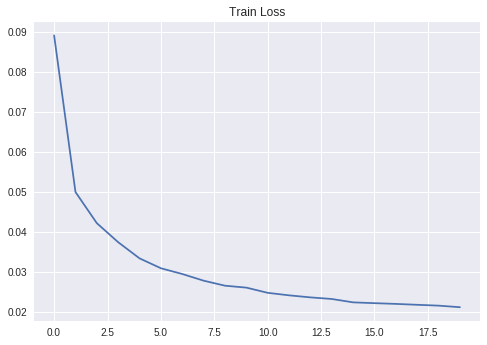

In [0]:
import matplotlib.pyplot as plt
train_losses = np.load('./CW/CAE/train_losses.npy')
plt.plot(list(range(0,train_losses.shape[0])), train_losses)
plt.title('Train Loss')
plt.show()

### Test set reconstruction error

In [0]:
# load the model
model.load_state_dict(torch.load('./CW/CAE/CAE_model.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(loader_test):
        img,_ = data
        img = img.to(device)
        recon_batch = model(img)
        test_loss += loss_function_CAE(recon_batch, img)
    # loss calculated over the whole test set
    test_loss /= len(loader_test.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))

Test set loss: 0.0002


### Test set images and reconstructions

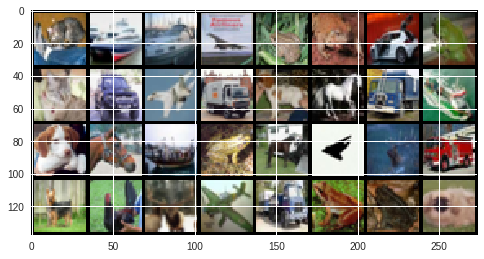

In [0]:
# load the model
model.load_state_dict(torch.load('./CW/CAE/CAE_model.pth'))
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

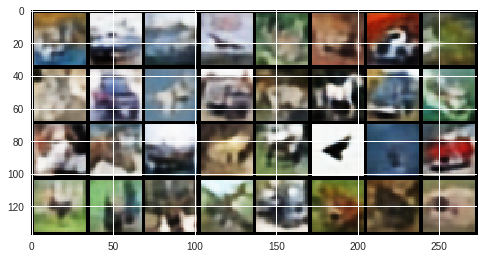

In [0]:
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    recon_batch = model(fixed_input.to(device)).cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    show(recon_batch)

### Part 1. 2 (20 points)
**Your Task**: 

In this part of the exercise you will use your pretrained encoder as a feature extractor in order to solve a downstream task:
* For every sample of your training set you will need to extract its latent representation by passing it through the encoder.
* Create a classifier of your choice and train it with the extracted features in order to predict the class that each image belongs to. You can access the sample's classes as follows:

`it = iter(loader_test)
samples, classes = next(it)`
* Use the encoder to encode all your test images into latent representations and then use your trained classifier to predict their classes
* Print the accuracy of your model.

The classifier can be trained with representations that do not yield very accurate reconstructions, so you can stop your training even if the reconstructed images are blurry. Also, note that you do not have to acheive high classification accuracy to get full marks for this question. Instead, focus on describing how you experimented in order to build your best classifier.

In [0]:
# *CODE FOR PART 1.2 IN THIS CELL*

#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

#build a Multilayer Perceptron(MLP) model for classification
num_classes= 10
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 1024) #batch,1024
        self.fc2 = nn.Linear(1024, 256) #batch,256
        self.fc3 = nn.Linear(256, 64) #batch,64
        self.fc4 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = x.view(-1,3*32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
#         return F.log_softmax(x)

In [0]:
#choose Adam as optimization algorithm and train this classifiction model within 30 epochs
#cross entropy function is used to determine the performance of this model 
model_classify = MLP().to(device)
optimizer = torch.optim.Adam(model_classify.parameters())
def train_MLP(epochs=20):
    model_classify.train()
    for epoch in range(epochs):
        t0=time()
        train_loss = 0
        for batch_idx, (samples,classes) in enumerate(loader_train):
            samples = samples.to(device=device)  # move to device, e.g. GPU
            classes = classes.to(device=device)
            optimizer.zero_grad()
            # forward
            recon_batch = model_classify(samples)
            #use cross entropy function as loss function
            loss = F.cross_entropy(recon_batch, classes)
            # backward
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        t1=time()
        print('epoch [{}/{}], loss:{:.4f}, time:{:.4f}s'
              .format(epoch + 1, epochs, train_loss / len(loader_train),t1-t0))
    torch.save(model.state_dict(), './CW/CAE/MLP_model.pth')
train_MLP(epochs=30)

epoch [1/30], loss:1.6613, time:14.6620s
epoch [2/30], loss:1.4362, time:14.8559s
epoch [3/30], loss:1.3161, time:14.6953s
epoch [4/30], loss:1.2140, time:14.6449s
epoch [5/30], loss:1.1326, time:14.5849s
epoch [6/30], loss:1.0440, time:14.6125s
epoch [7/30], loss:0.9587, time:14.8592s
epoch [8/30], loss:0.8760, time:14.8889s
epoch [9/30], loss:0.8039, time:14.7157s
epoch [10/30], loss:0.7262, time:14.6544s
epoch [11/30], loss:0.6629, time:14.7395s
epoch [12/30], loss:0.5945, time:14.6859s
epoch [13/30], loss:0.5406, time:14.9037s
epoch [14/30], loss:0.4918, time:14.9017s
epoch [15/30], loss:0.4418, time:14.9901s
epoch [16/30], loss:0.4001, time:14.9626s
epoch [17/30], loss:0.3743, time:15.2397s
epoch [18/30], loss:0.3458, time:15.0998s
epoch [19/30], loss:0.3266, time:15.3158s
epoch [20/30], loss:0.3000, time:15.1566s
epoch [21/30], loss:0.2896, time:15.0668s
epoch [22/30], loss:0.2592, time:15.0532s
epoch [23/30], loss:0.2619, time:15.1609s
epoch [24/30], loss:0.2407, time:15.0714s
e

In [0]:
#check accuracy for decoder
def check_accuracy(loader):
    print('Checking accuracy on test set')   
    num_correct = 0
    total_samples = 0
    model.eval()  # set model to evaluation mode
    model_classify.eval()
    with torch.no_grad():
        for i,(samples, classes) in enumerate(loader):
            samples = samples.to(device=device)  # move to device, e.g. GPU
            classes = classes.to(device=device)
            scores = model_classify(model(samples))
            preds = scores.max(1)[1] #return max index
            num_correct += (preds == classes).sum()
            total_samples += preds.size(0)
        acc = float(num_correct) / total_samples
    return acc
accuracy = check_accuracy(loader_test)
#######################################################################
#                       ** END OF YOUR CODE **
####################################################################### 
# name your accuracy variable as accuracy
print('Classification accuracy: {:.4f}'.format(accuracy))

Checking accuracy on test set
Classification accuracy: 0.5196


## Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plos with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse. 

_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get full marks. The attached model does not have to be perfect._

### Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

b. visualize images sampled from your best model's generator.

c. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).

For b. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

### Hyper-parameter selection

In [0]:
!pip install adabound

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*

### Choose the number of epoch, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 20
learning_rate  = 2e-4
print(learning_rate)
final_lr = 0.1
latent_vector_size = 64
###

# Define here other hyperparameters that you used.

0.0002


In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*
hidden_1 = 64
hidden_2 = 128
output = 256
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.decoder = nn.Sequential(
            # input latent_vector_size, going into a convolution
            nn.ConvTranspose2d(latent_vector_size, output, 4, 1, 0, bias=False),# batch, hidden_2, 4, 4
            nn.BatchNorm2d(output),
            nn.ReLU(True),
            nn.ConvTranspose2d(output, hidden_2, 4, 2, 1, bias=False),# batch, hidden_2, 8, 8
            nn.BatchNorm2d(hidden_2),
            nn.ReLU(True),
            nn.ConvTranspose2d( hidden_2, hidden_1, 4, 2, 1, bias=False),# batch, hidden_1, 16, 16
            nn.BatchNorm2d(hidden_1),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_1, 3, 4, 2, 1, bias=False),# batch, 3, 32, 32
            nn.Tanh()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = self.decoder(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return x

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.discriminate = nn.Sequential(
            # input is 3 x 32 x 32
            nn.Conv2d(3, hidden_1, 4, 2, 1, bias=False),#batch,hidden_1,16,16
            nn.BatchNorm2d(hidden_1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_1, hidden_2, 4, 2, 1, bias=False),#batch,hidden_2,8,8
            nn.BatchNorm2d(hidden_2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_2, output, 4, 2, 1, bias=False),#batch,output,4,4
            nn.BatchNorm2d(output),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(output, 1, 4, 1, 0, bias=False),#batch,1,1,1
            nn.Sigmoid()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def discriminator(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.discriminate(x)
#         print(out.shape)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        return out

    def forward(self, x):
        outs = self.discriminator(x)
        return outs.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 921472
Generator(
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


Total number of parameters in Discriminator is: 663424
Discriminator(
  (discriminate): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [0]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.

# beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# import adabound
# optimizerD = adabound.AdaBound(model_D.parameters(), lr=learning_rate, final_lr=final_lr)
# optimizerG = adabound.AdaBound(model_G.parameters(), lr=learning_rate, final_lr=final_lr)


### Define fixed input vectors to monitor training and mode collapse.

In [0]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [0]:
export_folder = './CW/DCGAN'
train_losses_G = []
train_losses_D = []
for epoch in range(num_epochs):
    for i, data in enumerate(loader_train, 0):
       
        t0=time()
        train_loss_D = 0
        train_loss_G = 0
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        #return a label of size (batch_size,)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        #Fills the tensor with the specified value.
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

        t1=time()
        if (i+1)%100==0 or  i== len(loader_train)-1:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f, time: %.4f s'
              % (epoch+1, num_epochs, i+1, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2,t1-t0))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()), './CW/DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()), './CW/DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

[1/20][100/383] Loss_D: 0.0767 Loss_G: 4.7407 D(x): 0.9532 D(G(z)): 0.0174 / 0.0163, time: 0.0791 s
[1/20][200/383] Loss_D: 0.0812 Loss_G: 4.6113 D(x): 0.9569 D(G(z)): 0.0329 / 0.0171, time: 0.0792 s
[1/20][300/383] Loss_D: 0.1471 Loss_G: 5.0813 D(x): 0.9905 D(G(z)): 0.1163 / 0.0109, time: 0.0788 s
[1/20][383/383] Loss_D: 0.1654 Loss_G: 4.6264 D(x): 0.9863 D(G(z)): 0.1294 / 0.0164, time: 0.0680 s
[2/20][100/383] Loss_D: 0.2567 Loss_G: 4.0095 D(x): 0.9245 D(G(z)): 0.1371 / 0.0307, time: 0.0789 s
[2/20][200/383] Loss_D: 0.1473 Loss_G: 3.6786 D(x): 0.9396 D(G(z)): 0.0718 / 0.0485, time: 0.0797 s
[2/20][300/383] Loss_D: 0.1146 Loss_G: 4.0679 D(x): 0.9541 D(G(z)): 0.0573 / 0.0371, time: 0.0798 s
[2/20][383/383] Loss_D: 0.1660 Loss_G: 3.9420 D(x): 0.9483 D(G(z)): 0.0896 / 0.0443, time: 0.0718 s
[3/20][100/383] Loss_D: 0.2283 Loss_G: 4.1117 D(x): 0.9119 D(G(z)): 0.1072 / 0.0288, time: 0.0803 s
[3/20][200/383] Loss_D: 0.1893 Loss_G: 4.4973 D(x): 0.9715 D(G(z)): 0.1345 / 0.0203, time: 0.0788 s


In [0]:
# save losses and models
np.save('./CW/DCGAN/train_losses_D.npy',np.array(train_losses_D))
np.save('./CW/DCGAN/train_losses_G.npy',np.array(train_losses_G))
torch.save(model_G.state_dict(), './CW/DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './CW/DCGAN/DCGAN_model_D.pth')

### Generator samples

**DISCUSS THE SELECTION OF THE ARCHITECTURE IN THIS CELL**


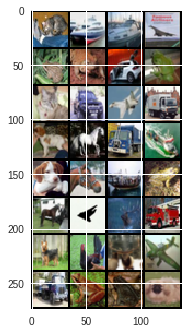

In [0]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

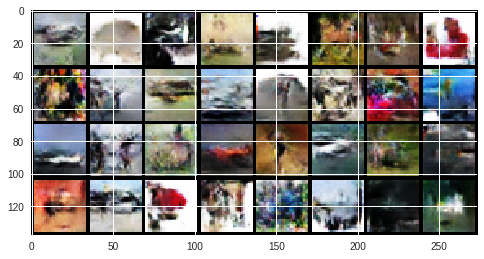

In [0]:
# load the model
model_G.load_state_dict(torch.load('./CW/DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

### Part 2.2 (10 points)

### Train losses curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

The code for generating the plot is already given. Make sure that the version of the notebook you deliver includes these results.

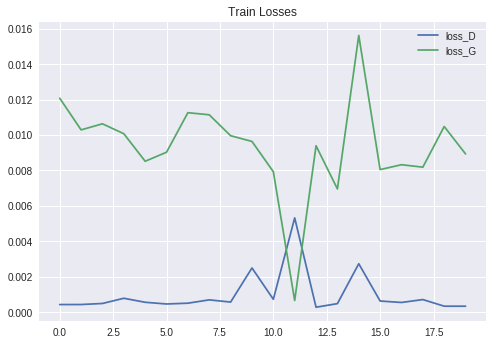

In [0]:
import matplotlib.pyplot as plt
train_losses_D = np.load('./CW/DCGAN/train_losses_D.npy')
train_losses_G = np.load('./CW/DCGAN/train_losses_G.npy')
plt.plot(list(range(0,train_losses_D.shape[0])), train_losses_D, label='loss_D')
plt.plot(list(range(0,train_losses_G.shape[0])), train_losses_G, label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()

**ANSWER FOR PART 2.2 IN THIS CELL**

In the first 13 epochs, the losses curves of discriminator and generator show a negative correlation that we can consider they are fighting each other. Our final goal of GAN is building a generator using a fixed noise to generate a fake image G(z) which make the corresponding discriminator believe.  In other words, D(G(z)) = 0.5, if the loss of discriminator is too low, we can say this discriminator is sensible enough to distinguish the outputs of the generator are fake, which is not our desired results. As we can see in the losses curves above, the loss of discriminator is increasing at first 13 epochs and the loss of generator drops at the same time, which is theoretically sensible. And the last few epochs tell us the generator and discriminator reached a balance.

### Part 2.3 (10 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

**ANSWER FOR PART 2.3 IN THIS CELL**

During the experiment, the model did collapse when a small learning rate or the inappropriate CNN architecture were used. In the result, a vanishing loss of discriminator was got which lead to the halt of the training of generator. The hyper-parameter including learning rate, batch size and the size of fixed noise vector, etc were re-tuned again and again to avoid model collapse. In this process, the architecture was also reconstructed several times including the adjustment of the size of hidden layer and the number of convolution layer.
